# Quantum Edge Detection

This demonstration shows how to use Qiskit™ to perform edge detection in images with the quantum Hadamard edge detection algorithm, which completes the task with just one single-qubit operation, independent of the size of the image, illustrating the potential of quantum image processing for highly efficient image and video processing.

Read the example image in and display it.

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

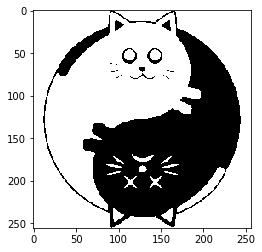

In [2]:
filename = './schrodin_yang.png'
im = mpimg.imread(filename)

fig, ax = plt.subplots()
ax.imshow(im)

If necessary, shrink the image to make the rest of the demonstration run faster.

In [3]:
from skimage.transform import resize

/miniconda3/envs/QiskitPublic/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/miniconda3/envs/QiskitPublic/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


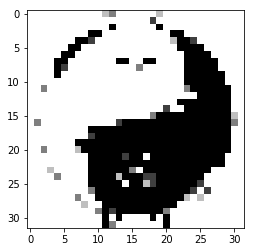

In [4]:
n_pixels = 2**5
im = resize(im, (n_pixels, n_pixels))

fig, ax = plt.subplots()
ax.imshow(im)

Get the first color channel of the image and `ravel` it to form a 1-D vector.

In [5]:
data = im[:,:,0].ravel()

Represent the image as a quantum state

$$ |A\rangle = \sum_k \alpha_k |k\rangle $$

where the computational basis $|k\rangle$ encodes the position of each pixel and the amplitude $\alpha_k$ encodes the pixel value.

In [6]:
from qiskit_aqua.components.initial_states import Custom

/miniconda3/envs/QiskitPublic/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [7]:
n_qubits   = np.int_(np.log2(len(data)))
init_state = Custom(n_qubits, state_vector=data)

Get the quantum circuit that creates the image representation and its registers. The circuit's registers begin in the zero state and end in the state that represents the image.

In [8]:
circ = init_state.construct_circuit('circuit')
qr   = circ.qregs

Create a copy of this circuit to try out different algorithms without having to regenerate it.

In [9]:
from copy import deepcopy

In [10]:
circ_init = deepcopy(circ)

The positions of any pair of neighboring pixels in `im` are the binary sequences $\{b_{n-1},\ldots, b_1, 0\}$ and $\{b_{n-1},\ldots, b_1, 1\}$, with $b_j = 0$ or $1$, their pixel values are stored as the amplitudes $\alpha_{\{b_{n-1},\ldots, b_1, 0\}}$ and $\alpha_{\{b_{n-1},\ldots,b_1,1\}}$ of the associated computational basis states. The Hadamard gate $H$ maps $|0\rangle \rightarrow (|0\rangle + |1\rangle)/\sqrt{2}$ and $|1\rangle \rightarrow (|0\rangle - |1\rangle)/\sqrt{2}$. Performing a Hadamard gate on the least significant qubit changes the amplitudes to $\alpha_{\{b_{n-1},\ldots,b_1,0\}} \pm \alpha_{\{b_{n-1},\ldots,b_1,1\}}$. The even elements of the resulting state ($\alpha_{\{b_{n-1},\ldots,b_1,0\}} - \alpha_{\{b_{n-1},\ldots,b_1,1\}}$) form the nearest neighboring pixel value differences that indicate edges when its values are non-zero.

The edge information in the even positions can be extracted by measuring the least significant qubit. If its value is $1$, then the state of the other $n-1$ quibits encodes the edges. The result is the horizontal boundaries between pixels at positions 0/1, 2/3, etc.

Applying the Hadamard gate on the least significant qubit can be represented as the tensor matrix product

$$ I_{2^{n-1}} \otimes H : 
\begin{pmatrix} 
\alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \vdots \\ \alpha_{N-2} \\ \alpha_{N-1} 
\end{pmatrix} 
\mapsto
\frac{1}{\sqrt{2}}
\begin{pmatrix} 
\alpha_0+\alpha_1 \\ \alpha_0-\alpha_1 \\ \alpha_2+\alpha_3 \\ \alpha_2-\alpha_3 \\ \vdots \\ \alpha_{N-2}+\alpha_{N-1} \\ \alpha_{N-2}-\alpha_{N-1} 
\end{pmatrix} 
$$

Beginning with the circuit `circ`, which initialized the state in the image representation, apply the Hadamard gate to the least significant qubit and measure it.

In [11]:
circ.h(qr[0][0])

In [12]:
from qiskit import ClassicalRegister, QuantumCircuit

In [13]:
c = ClassicalRegister(1)
meas = QuantumCircuit(qr[0],c)
meas.measure(qr[0][0],c[0])

In [14]:
circuit = circ + meas

Simulate the circuit using the `StatevectorSimulator` and read the resulting state vector.

In [15]:
from qiskit import BasicAer, execute

In [16]:
simulator = BasicAer.get_backend('statevector_simulator')

#from qiskit import Aer, execute
#from qiskit.providers.Aer import StatevectorSimulator
#simulator = Aer.get_backend('statevector_simulator')

In [17]:
result = execute(circuit, simulator).result()

final_state_vector = result.get_statevector(circuit)

/miniconda3/envs/QiskitPublic/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


Decode the state vector back into an image.

In [18]:
edge_even = np.real(final_state_vector)
n_rows    = np.int_(np.sqrt(len(edge_even)))
edge_even = edge_even.reshape(n_rows, -1)

Conditioned on the measurement result of the least significant qubit being $1$, the state of the other $n − 1$ qubits encodes the domain boundaries. After decoding the 1-D state vector back into a 2-D image, the even column indices correspond to the least significant qubit being $1$, so to retain only these columns, zero out the odd columns.

In [19]:
edge_even[:,::2] = 0

Display the edges and the original image for comparison.

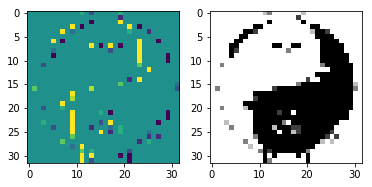

In [20]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(edge_even)
ax[1].imshow(im)

So far, the boundaries have been found between the pixels at position 0/1, 2/3, etc. To get the boundaries between the remaining pairs 1/2, 3/4, etc., apply the $n$-qubit amplitude permutation that swaps the even and odd amplitudes.

$$ D_{2^{n}} : 
\begin{pmatrix} 
\alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \vdots \\ \alpha_{N-2} \\ \alpha_{N-1} 
\end{pmatrix} 
\mapsto
\begin{pmatrix} 
\alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \alpha_4 \\ \vdots \\ \alpha_{N-1} \\ \alpha_{0} 
\end{pmatrix} 
$$

$$ (I_{2^{n-1}} \otimes H) D_{2^{n}} : 
\begin{pmatrix} 
\alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \alpha_3 \\ \vdots \\ \alpha_{N-2} \\ \alpha_{N-1} 
\end{pmatrix} 
\mapsto
\frac{1}{\sqrt{2}}
\begin{pmatrix} 
\alpha_1+\alpha_2 \\ \alpha_1-\alpha_2 \\ \alpha_3+\alpha_4 \\ \alpha_3-\alpha_4 \\ \vdots \\ \alpha_{N-1}+\alpha_{0} \\ \alpha_{N-1}-\alpha_{0} 
\end{pmatrix} 
$$

Build the permutation operation.

In [21]:
def qft(circ, q, n):
    """n-qubit QFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(pi/float(2**(j-k)), q[j], q[k])
        circ.h(q[j])
        
def iqft(circ, q, n):
    """n-qubit IQFT on q in circ."""
    for j in range(n):
        for k in range(j):
            circ.cu1(-pi/float(2**(j-k)), q[int(n-j-1)], q[int(n-k-1)])
        circ.h(q[int(n-j-1)])
        
def shiftBases(circ, q, n):
    iqft(circ,q,n)
    for k in range(n):
        circ.u1(-2*pi/float(2**(n-k)), q[int(n-k-1)])
    qft(circ,q,n)

In [22]:
from qiskit import QuantumRegister

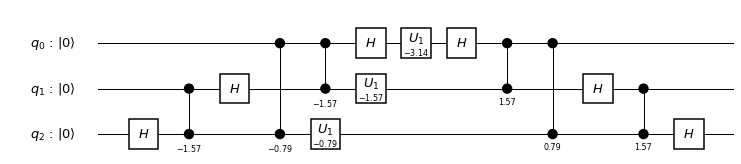

In [23]:
n = 3
q = QuantumRegister(n,'q')
c = QuantumCircuit(q)

shiftBases(c,q,n)

c.draw(output='mpl')

Verify the circuit performs a permutation by looking at the matrix form of the circuit.

In [24]:
simulator = BasicAer.get_backend('unitary_simulator')
result = execute(c, simulator).result()
unitary = result.get_unitary(c)
print(unitary)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]]


Apply the permutation to the copy of image initialization circuit to avoid recalculating the image to state vector encoding.

In [25]:
circ = deepcopy(circ_init)
qr   = circ.qregs

In [26]:
shiftBases(circ,qr[0],n_qubits)

circ.h(qr[0][0])

circuit = circ + meas

In [27]:
simulator = BasicAer.get_backend('statevector_simulator')
result = execute(circuit, simulator).result()
final_state_vector = result.get_statevector(circuit)

In [28]:
edge_odd = np.real(final_state_vector)
n_rows = np.int_(np.sqrt(len(edge_odd)))
edge_odd = edge_odd.reshape(n_rows, -1)
#edge_odd[:,1::2] = 0

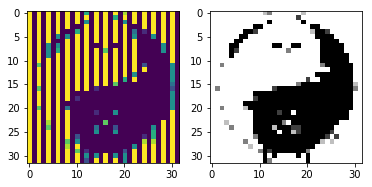

In [29]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(edge_odd)
ax[1].imshow(im)

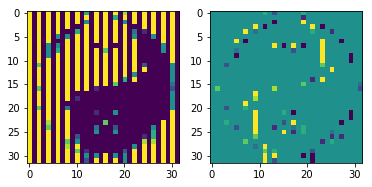

In [30]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(edge_odd)
ax[1].imshow(edge_even)

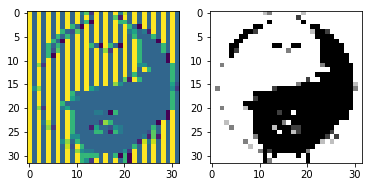

In [31]:
edge = edge_even + edge_odd
fig, ax = plt.subplots(1,2)
ax[0].imshow(edge)
ax[1].imshow(im)